In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.coordinates as coord
from astropy.time import Time
from astropy import units as u
from tqdm import tqdm

### Load up Gaia results
#### (see adql_query.txt for query)

In [2]:
gaia = np.genfromtxt('../hjhosts-result.csv', delimiter=',', unpack=True, names=True, dtype=None, encoding=None)

In [3]:
table = pd.DataFrame.from_records(gaia)

In [4]:
table = table.rename(columns={'col1':'kep_ra', 'col2':'kep_dec', 'col3':'kepmag', 'col4':'kepid'})

#### Calculate better angular separations that take propagated proper motion into account:

In [5]:
refCoord = coord.SkyCoord(ra=table['kep_ra'].values * u.degree, 
                          dec=table['kep_dec'].values * u.degree)        

In [16]:
table['radial_velocity'][np.isnan(table['radial_velocity'])] = 0.
gaia_time = Time(table['ref_epoch'], format='jyear')
kepler_time = Time(2004, format='jyear') # GUESS
gaiaCoord = coord.SkyCoord(ra=table['ra'].values * u.degree, 
                           dec=table['dec'].values * u.degree, 
                           distance=(np.zeros_like(table['ra'].values) + 100.) * u.kpc, # HACK
                           radial_velocity=np.zeros_like(table['ra'].values) * u.km / u.s, # HACK
                           pm_ra_cosdec=table['pmra'].values * u.milliarcsecond / u.year, 
                           pm_dec=table['pmdec'].values * u.milliarcsecond / u.year, 
                           obstime=gaia_time
                            )
gaiaCoord_shifted = gaiaCoord.apply_space_motion(new_obstime=kepler_time)
sep = refCoord.separation(gaiaCoord_shifted)
#ind = np.where(sep > 10. * u.deg)[0]
#for i in ind:
#        sep[i] = 180.*u.deg - sep[i] # HACK

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/distances.py:162: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-package

In [17]:
table['ang_dist_w_pm'] = sep.arcsec

In [21]:
table['ra_keptime'] = gaiaCoord_shifted.ra.degree
table['dec_keptime'] = gaiaCoord_shifted.dec.degree

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_

Check on the best matches:

In [22]:
matches = table.sort_values(['kepid', 'ang_dist_w_pm'], inplace=False)
matches.drop_duplicates('kepid', inplace=True)

(array([256.,   1.,   0.,   3.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([3.61220437e-03, 1.77017480e+00, 3.53673739e+00, 5.30329998e+00,
        7.06986257e+00, 8.83642516e+00, 1.06029878e+01, 1.23695503e+01,
        1.41361129e+01, 1.59026755e+01, 1.76692381e+01]),
 <a list of 10 Patch objects>)

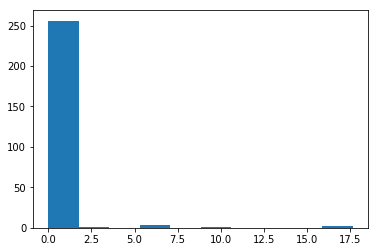

In [23]:
plt.hist(matches['ang_dist_w_pm'])

In [24]:
matches[matches['ang_dist_w_pm'] > 5.]

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,epoch_photometry_url,hjhosts_oid,kep_ra,kep_dec,kepmag,kepid,ang_dist,ang_dist_w_pm,ra_keptime,dec_keptime
23910,1635721458409799680,Gaia DR2 2101508501301082368,2101508501301082368,1004772443,2015.5,291.283725,0.027139,40.727728,0.037741,0.382788,...,,115,291.28500,40.730049,15.855,5531953,0.002514,8.980513,291.283727,40.727748
43979,1635721458409799680,Gaia DR2 2076660672388510464,2076660672388510464,1039014877,2015.5,294.960202,0.072132,40.985350,0.098499,0.100101,...,,208,294.96027,40.986980,15.423,5716244,0.001631,5.842321,294.960208,40.985358
48799,1635721458409799680,Gaia DR2 2080091492257542144,2080091492257542144,325514623,2015.5,294.993792,0.206241,46.223899,0.212958,0.269455,...,,234,294.99121,46.223572,14.538,9596187,0.001816,6.591236,294.993809,46.223918
18147,1635721458409799680,Gaia DR2 2086324275778825600,2086324275778825600,184412114,2015.5,297.652861,0.211104,47.167175,0.206432,0.154450,...,,90,297.64606,47.167488,13.592,10158418,0.004634,16.705680,297.652871,47.167183
21791,1635721458409799680,Gaia DR2 2130856356427181568,2130856356427181568,349879453,2015.5,287.706976,0.324227,47.333921,0.559335,0.027589,...,,104,287.70883,47.333050,12.128,10264660,0.001529,5.524671,287.706977,47.333932
39409,1635721458409799680,Gaia DR2 2119616182197267200,2119616182197267200,981221805,2015.5,281.772358,0.145839,47.597664,0.166030,0.227139,...,,191,281.77554,47.593250,14.371,10384962,0.004908,17.669238,281.772505,47.597711


In [26]:
from utils import *

In [27]:
kepids = np.unique(table['kepid'].values)

In [28]:
columns = ['kic_primary','gaia_id_primary', 'gaia_id_match', 'ra_match_keptime', 
           'dec_match_keptime', 'ra_match_gaia', 'dec_match_gaia', 'chisq']
matches_table = pd.DataFrame(columns=columns)

In [29]:
gaia_time = Time(table['ref_epoch'][0], format='jyear')
kepler_time = Time('J2000')

def add_to_matches_table(match, primary, chisq, matches_table):
    matches_table = matches_table.append({'kic_primary': primary['kepid'], 
                          'gaia_id_primary': primary['source_id'], 
                          'gaia_id_match': match['source_id'], 
                          'ra_match_keptime': match['ra_keptime'], 
                          'dec_match_keptime': match['dec_keptime'], 
                          'ra_match_gaia': match['ra'],
                          'dec_match_gaia': match['dec'],
                          'chisq': chisq}, ignore_index=True)
    return matches_table

In [30]:
for k in tqdm(kepids):
    temp = table[table['kepid'] == k]
    best_match = temp.loc[temp['ang_dist_w_pm'].idxmin()]
    if best_match['ang_dist_w_pm'] > 1.:
        continue
    other_matches = temp.drop(temp['ang_dist_w_pm'].idxmin())
    chisqs = other_matches.apply(calc_chisq_for_pair, axis=1, args=(best_match,))
    for o,c in zip(other_matches.iterrows(), chisqs):
        if c > 0.:
            matches_table = add_to_matches_table(o[1], best_match, c, matches_table)


  2%|▏         | 5/263 [00:03<03:21,  1.28it/s]Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 263/263 [03:42<00:00,  1.18it/s]


In [31]:
matches_table.to_csv('matches.csv')